In [239]:
#pip install cvxpy[GLPK,SCIP]

In [240]:
from cvxpy import *

print(installed_solvers())

['CLARABEL', 'CPLEX', 'ECOS', 'ECOS_BB', 'GUROBI', 'MOSEK', 'OSQP', 'SCIP', 'SCIPY', 'SCS']


# **Aircraft Trajectory Planning With Collision Avoidance Using Mixed Integer Linear Programming**


[Richards, A., & How, J. P. (2002). Aircraft trajectory planning with collision avoidance using mixed integer linear programming. Proceedings of the American Control Conference](https://doi.org/10.1109/ACC.2002.1023918)


- Other references from the same main author:

[Richards, A. G. (2002). Trajectory Optimization using Mixed-Integer Linear Programming. MASSACHUSETTS INSTITUTE OF TECHNOLOGY](https://www.mit.edu/people/jhow/Richards_SM.pdf)

[Richards, A., & How, J. (2005). Mixed-integer programming for control. Proceedings of the American Control Conference, 2676–2683](https://doi.org/10.1109/ACC.2005.1470372)

[Richards, A., & Turnbull, O. (2013). Inter-sample avoidance in trajectory optimizers using mixed-integer linear programming. AIAA Guidance, Navigation, and Control Conference, 1–9](https://doi.org/10.2514/6.2013-4634)

- Additional refereces of various authors:

[Schouwenaars, T., De Moor, B., Feron, E., & How, J. (2001). Mixed integer programming for multi-vehicle path planning. Proceedings of the European Control Conference](https://doi.org/10.239195/ecc.2001.7076321)

[Schouwenaars, T., How, J., & Feron, E. (2004). Receding horizon path planning with implicit safety guarantees. Proceedings of the European Control Conference](https://doi.org/10.23919/acc.2004.1384742)

[Schouwenaars, T. (2006). Safe Trajectory Planning of Autonomous Vehicles. MASSACHUSETTS INSTITUTE OF TECHNOLOGY](http://hdl.handle.net/1721.1/35298)

[Culligan, K. F. (2006). Online trajectory planning for uavs using mixed integer linear programming. MASSACHUSETTS INSTITUTE OF TECHNOLOGY](http://dspace.mit.edu/handle/1721.1/37952)

[Liying Yang, Juntong Qi, & Jianda Han. (2012). Path planning methods for mobile robots with linear programming. Proceedings of the International Conference on Modelling, Identification and Control](https://ieeexplore.ieee.org/document/6260329)

## **Plotting**

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams.update({'font.size': 8})


def plot(T=None, C=None, F=None, S=None, s0=None, sf=None):
    '''
    S : 2-dimensional array (4, n)

    S[0,:] --> x
    S[1,:] --> xdot
    S[2,:] --> y
    S[3,:] --> ydot
    '''
    fig = plt.figure(figsize=(5, 6));
    ax = fig.subplots(3, 1, height_ratios=[3,1,1]);

    if S is not None and T is not None:
        V = np.sqrt(S[1,:]**2 + S[3,:]**2)
        FF = np.sqrt(F[0,:]**2 + F[1,:]**2)

        ax[0].plot(S[0,:], S[2,:], '.-r');

        ax[1].plot(T, V, '.-r', label='$|v|$');
        ax[1].plot(T, S[1,:], '.-g', label='$v_x$');
        ax[1].plot(T, S[3,:], '.-b', label='$v_y$');
        ax[1].legend()

        ax[2].plot(T[0:-1], FF, '.-r', label='$|f|$');
        ax[2].plot(T[0:-1], F[0,:], '.-g', label='$f_x$');
        ax[2].plot(T[0:-1], F[1,:], '.-b', label='$f_y$');
        ax[2].legend()
    
    if s0 is not None:
        ax[0].plot(s0[0], s0[2], 'ob', markersize=10);

    if sf is not None:
        sf = np.reshape(sf,(-1,4))
        ax[0].plot(sf[:,0], sf[:,2], 'dg', markersize=8);

    if C is not None:
        RECTS = []
        for k in range(len(C)):
            RECTS.append(patches.Rectangle((C[k,0], C[k,2]),
                                        np.abs(C[k,0]-C[k,1]),
                                        np.abs(C[k,2]-C[k,3]),
                                        linewidth=1, edgecolor='k', facecolor='k')
        )

        for k in range(len(RECTS)):
            ax[0].add_patch(RECTS[k])

    ax[0].set_aspect('equal');
    ax[0].axis('equal');
    ax[0].set_xlabel('$x$');
    ax[0].set_ylabel('$y$');

    ax[1].set_xlabel('Time (s)');
    ax[1].set_ylabel('$|v|$');

    ax[2].set_xlabel('Time (s)');
    ax[2].set_ylabel('$|f|$');

    plt.tight_layout()


def plot_turn_rate(T, S, F, m):
    w = np.zeros(len(T))
    v = S[1::2, :]
    for k in range(len(T)):
        w[k] = np.rad2deg(np.linalg.norm(F[:,k]) / (m * np.linalg.norm(v[:,k])))

    fig = plt.figure(figsize=(5, 2));
    ax = fig.subplots();
    ax.plot(T, w, '.-r')
    ax.grid();
    ax.set_xlabel('Time (s)');
    ax.set_ylabel('Turn rate (deg/s)');

    plt.tight_layout()

## **Test environments**

In [242]:
import numpy as np

%matplotlib inline


'''
Given an following array: (xmin, xmax, ymin, ymax)
This corresponds to a rectangle  with:
  lower-left corner located at (xmin, ymin)
  width = abs(xmax - xmin)
  height = abs(ymax - ymin)
'''

def create_env1():
    # Figure 4
    C = np.array([[-4,-3, 3.5, 6],
                  [ 2, 3,   3, 9],
                  [ 0, 1,   1, 5]], dtype=np.float32)
    return C

def create_env2():
    # Figure 9
    C = np.array([[1, 3, 0, 8]], dtype=np.float32)
    return C

## **System model**

The vehicle is modeled as a simple 2-D discrete double integrator.


$$
\begin{bmatrix}
x_{i+1}\\
v_{x_{i+1}}\\
y_{i+1}\\
v_{y}{}_{_{i+1}}
\end{bmatrix} =\begin{bmatrix}
1 & \Delta t & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & \Delta t\\
0 & 0 & 0 & 1
\end{bmatrix}\begin{bmatrix}
x_{i}\\
v_{x_{i}}\\
y_{i}\\
v_{y_{i}}
\end{bmatrix} +\frac{1}{m}\begin{bmatrix}
0.5\Delta t^{2} & 0\\
\Delta t & 0\\
0 & 0.5\Delta t^{2}\\
0 & \Delta t
\end{bmatrix}\begin{bmatrix}
f_{x}\\
f_{y}
\end{bmatrix}
$$

In [243]:
import numpy as np

def generate_model(dt, mass):
    A = np.array([[1.,   dt,  0., 0. ], # x
                [0.,   1,   0., 0. ],    # xdot
                [0.,   0.,  1., dt ],    # y
                [0.,   0.,  0., 1, ]])   # ydot
    B = 1.0 / mass * np.array([[0.5*dt**2, 0.        ],
                                [dt,        0.        ],
                                [0.,        0.5*dt**2 ],
                                [0.,        dt        ]])
    return A, B

The parameters are mentioned in Section 4 of the paper.

$$
\begin{equation}
\begin{aligned}
m &= 5 \, \text{kg}\\
\Delta t &=  2 \, \text{s}\\
T &= 60 \text{s}\\
v_{\text{max}} &= 0.225 \, \text{m/s}\\
\epsilon &= 0.001\\  
\end{aligned}
\end{equation}
$$

Note that $\epsilon_v$ is our additional parameter.

## **Planning**

Constraint programming:

- Dynamic constraints (Section 2.2)
- Collision avoidance (Section 2.3)
- Minimum time trajectory (Section 2.4)
- Multiple waypoints (Section 2.5)

We expand the minimum time equation that is expressed in eq. (9) to also include velocity. If the velocity is set to ```None```, the previous velocity constraints remain valid.

$$
\begin{equation}
\begin{aligned}
& \forall i \in[1 \ldots T] \\
& x_{\mathrm{ip}}-x_{\mathrm{F}} \leq R\left(1-b_{\mathrm{i}}\right) \\
\text { and }& x_{\mathrm{i}}-x_{\mathrm{F}} \geq-R\left(1-b_{\mathrm{i}}\right) \\
\text { and }& y_{\mathrm{i}}-y_{\mathrm{F}} \leq R\left(1-b_{\mathrm{i}}\right) \\
\text { and }& y_{\mathrm{i}}-y_{\mathrm{F}} \geq -R\left(1-b_{\mathrm{i}}\right) \\
\text { and }& v_{x_\mathrm{i}}-v_{x_{\mathrm{F}}} \leq R\left(1-b_{\mathrm{i}}\right) \\
\text { and }& v_{x_\mathrm{i}}-v_{x_{\mathrm{F}}} \geq-R\left(1-b_{\mathrm{i}}\right) \\
\text { and }& v_{y_\mathrm{i}}-v_{y_{\mathrm{F}}} \leq R\left(1-b_{\mathrm{i}}\right) \\
\text { and }& v_{y_\mathrm{i}}-v_{y_{\mathrm{F}}} \geq -R\left(1-b_{\mathrm{i}}\right) \\
\\
&\sum_{i=1}^T b_{\mathrm{i}}=1
\end{aligned}
\end{equation}
$$


As for the objective function, instead of using ```norm1``` in Eq. (12), we will use ```norm2```. Thus, the objective function now becomes:
$$
\min_{s,f,b,c} J=\sum _{i=1}^{T} T_{i} b_{i} +\epsilon\sum _{i=0}^{T-1}({\| f_{i}\|}_2 )
$$

The "tight turns around obstacle corners" that can be seen in Fig. 4 of the paper was actually the shorter distance from source to the destination. Due to the accuracy of the constraints that we use, minimum time does not always mean minimum distance. Thus, if we need to improve the accuracy of our constraints by using ```norm2``` in the objective function.

Some discussion with Prof. Richards directed me to the following repository:

https://github.com/arthurrichards77/pytro (see the file: ```aircraft_example.py```)

In Prof. Richard re-implementation, we can see how ```norm2``` is used intead of ```norm1```. However, ```norm2``` is a nonlinear operation. Here we will use the same polygonal approximation similar to the previous turn-rate constraints (velocity and force constraints). Next, we increase number of sides of the polygonal approximation for the force and velocity constraints to $M=20$. 

Finally, we also corrcet the $v_{\text{max}}$ to $v_{\text{max}}^{'}$ according to Culligan thesis, p.31, eq. (2.12).

In [244]:
from cvxpy import *


def plan2(N, s0, sf, C=None, wmax=np.deg2rad(15.0), mass=1.0, vmax=0.225, dt=2.0, LPN=20, solver="SCIP"):
    '''
    N is the horizon length.
    s0 is the initial state.
    sf is the terminal state.
    wmax is the maximum turn rate.
    vmax is the maximum speed.
    mass is the mass of the vehicle, modeled as a double integrator.
    dt is the sampling period
    LPN (Large Positve Number) is a positive number that is much larger than any position or velocity to be encountered in the problem.
    solve
    '''

    A, B = generate_model(dt, mass)
    [ns, nf] = B.shape

    # Define problem
    f = Variable((nf, N)) # input variables
    s = Variable((ns, N+1)) # state variables, make S[N] as the terminal state

    # Constraints for the intial states
    constraints  = [s[:,0] == s0]  # eq. (4)

    # System dynamics constraints
    for k in range(N):
        constraints += [s[:,k+1] == A@s[:,k] + B@f[:,k]]  # eq. (3)

    # Velocity-force dynamic constraints, polytopic approximation of a circle
    M = 20 # number of the polygon sides

    vmax = vmax * np.cos(np.pi/M) # correction factor as explained in Culligan thesis, p.31, eq. (2.12)
    fmax = wmax * mass * vmax  # See eq. (2)
    
    print("vmax' =", vmax)    
    print('fmax =', fmax)
    
    # norm2(f) = fmax
    for k in range(N):
        for m in range(1,M+1):
            constraints += [(f[0,k]*np.sin(2*np.pi*m/M) + f[1,k]*np.cos(2*np.pi*m/M)) <= fmax]  # eq. (6)

    # norm2(v) = vmax
    for k in range(1,N+1):
        for m in range(1,M+1):
            constraints += [(s[1,k]*np.sin(2*np.pi*m/M) + s[3,k]*np.cos(2*np.pi*m/M)) <= vmax]  # eq. (7)

    # Collision avoidance
    if C is not None:
        C = np.reshape(C, (-1,4))
        L = len(C) # Number of the rectangular obstacles
        c1 = Variable((L, N+1), boolean=True)
        c2 = Variable((L, N+1), boolean=True)
        c3 = Variable((L, N+1), boolean=True)
        c4 = Variable((L, N+1), boolean=True)


        d = 0.0 # safety distance, 2 cm, not mentioned in the paper
        for k in range(1,N+1): # from 1 to N, exclude initials
            for l in range(L):  # eq. (8)
                constraints += [s[0,k]  <=  (C[l, 0] - d) + LPN*c1[l,k],
                                -s[0,k] <= -(C[l, 1] + d) + LPN*c2[l,k],
                                s[2,k]  <=  (C[l, 2] - d) + LPN*c3[l,k],
                                -s[2,k] <= -(C[l, 3] + d) + LPN*c4[l,k]]
                constraints += [c1[l,k] + c2[l,k] + c3[l,k] + c4[l,k] <= 3]

    # Minimum time constraints + waypoint constraints
    sf = sf.reshape(-1, 4)
    W = len(sf)
    b  = Variable((W, N+1), boolean=True)
    Tf = Variable(1) # Minimum finishing time

    for w in range(W):  # eq. (13)
        tf = 0.0
        for k in range(1,N+1):
            # for positions
            constraints += [(s[0,k]-sf[w,0]) <=  LPN*(1-b[w,k]),
                            (s[0,k]-sf[w,0]) >= -LPN*(1-b[w,k]),
                            (s[2,k]-sf[w,2]) <=  LPN*(1-b[w,k]),
                            (s[2,k]-sf[w,2]) >= -LPN*(1-b[w,k])]
            
            if np.isnan(sf[w,1]) == False:
                 constraints += [(s[1,k]-sf[w,1]) <=  LPN*(1-b[w,k]),
                                 (s[1,k]-sf[w,1]) >= -LPN*(1-b[w,k])]
            if np.isnan(sf[w,3]) == False:
                 constraints += [(s[3,k]-sf[w,3]) <=  LPN*(1-b[w,k]),
                                 (s[3,k]-sf[w,3]) >= -LPN*(1-b[w,k])]

            tf += k*dt*b[w,k]

        constraints += [1 == sum(b[w, 1:])]  # eq. (14)
        constraints += [Tf >= tf]  # eq. (15)

    # Polytopic approximation of norm2(f) 
    # Here we are computing the actual norm2(f)
    # We are not constraining the norm2(f)
    norm2f = Variable(N)
    M = 10
    for k in range(N):
        for m in range(1,M+1):
            constraints += [(f[0,k]*np.sin(2*np.pi*m/M) + f[1,k]*np.cos(2*np.pi*m/M)) <= norm2f[k]]
           
    # The objective
    epsilon = 0.001
    J = Tf + epsilon*sum(norm2f) # eq. (16)

    prob = Problem(Minimize(J), constraints)

    res = prob.solve(solver=solver, verbose=False, warm_start=True)
    print('Tf =', Tf.value)
    print('J =',res)

    return s.value, f.value, Tf.value

## **Point to point**

In [245]:
# Initial and final states, mentioned in Section 4.1
s0 = np.array([ 5., -0.2, 5., 0.]) # x, vx, y, vy
sf = np.array([-5., -0.2, 4., 0.]) # x, vx, y, vy

# Prediction horizon
tf = 60.
dt = 2.0
N = np.int32(tf/dt)

C = create_env1()

### Maximum turn rate = 15 deg/s

$\omega_{\text{max}}=15 ^{\circ}/\text{s}$

Notice the "tight turns around obstacle corners". The generated minimum time trajectory is also the minimum distance trajectory.

In [246]:
s, f, T = plan2(C=C, N=N, s0=s0, sf=sf, wmax=np.deg2rad(15.0), mass=5.0, dt=dt, solver="SCIP")

vmax' = 0.222229876633906
fmax = 0.2908982282671854
Tf = [56.]
J = 56.00306912610512


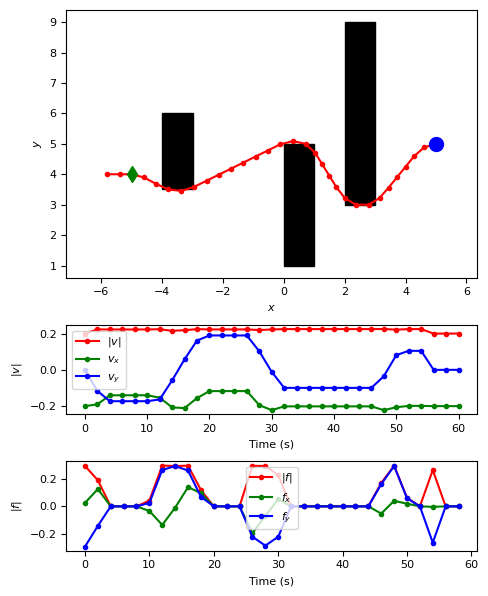

In [247]:
%matplotlib inline

time_span = np.linspace(0, tf, N+1)
plot(T=time_span, C=C, F=f, S=s, s0=s0, sf=sf)

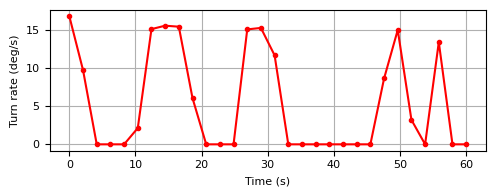

In [248]:
%matplotlib inline

time_span = np.linspace(0, tf, N)
plot_turn_rate(T=time_span, S=s, F=f, m=5.0)

### Maximum turn rate = 12 deg/s

$\omega_{\text{max}}=12 ^{\circ}/\text{s}$


Notice that the tight turns dissapear. The generated minimum time trajectory does not have the minimum distance.

In [249]:
s, f, Tf = plan2(C=C, N=N, s0=s0, sf=sf, wmax=np.deg2rad(12.0), mass=5.0, dt=2.0, solver="SCIP")

vmax' = 0.222229876633906
fmax = 0.23271858261374842
Tf = [58.]
J = 58.00139798916619


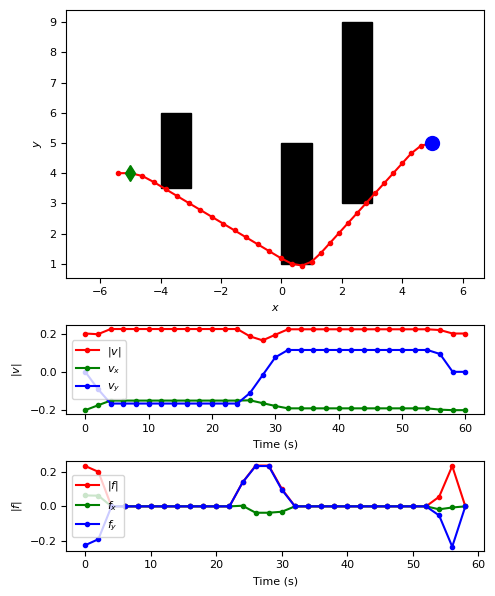

In [250]:
%matplotlib inline

time_span = np.linspace(0, tf, N+1)
plot(T=time_span, C=C, F=f, S=s, s0=s0, sf=sf)

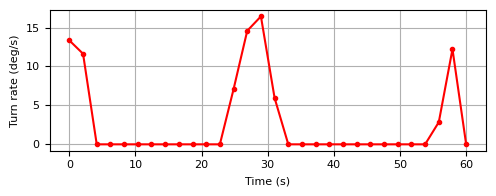

In [251]:
%matplotlib inline

time_span = np.linspace(0, tf, N)
plot_turn_rate(T=time_span, S=s, F=f, m=5.0)

## Multiple waypoints

Similar to minimim time trajector, the waypoints also include the velocities. 

Assume that there are $W$ waypoints and the position of the $k^{\text {th }}$ waypoint is $\left(x_{\mathrm{W}\mathrm{k}}, y_{\mathrm{W}\mathrm{k}}, v_{x_{\mathrm{W}\mathrm{k}}}, v_{y_{\mathrm{W}\mathrm{k}}}\right)$. 

Although not mentioned in the paper, here we will set the $\omega_{\text{max}}=15 ^{\circ}/\text{s}$.

In every waypoint, the velocity is set to ```None```. This means the previous velocity constraints with polytopic approximation will be used.

### Experiment 1

In [252]:
                                                                                                                                                                                                            # Based on Fig. 8
# Initial and final states
s0 = np.array([-7., 0., 5., 0.])

# Prediction horizon
tf = 90.0
N = np.int32(tf/dt)

# Format: [x, y, vx, vy]
sf = np.array([[-2, None, 6, None],
               [ 6, None, 4, None],
               [ 7, None, 8, None]], dtype=np.float32)

s, f, Tf = plan2(N=N, s0=s0, sf=sf, wmax=np.deg2rad(15.0), mass=5., dt=2., solver="SCIP")

vmax' = 0.222229876633906
fmax = 0.2908982282671854
Tf = [84.]
J = 84.00157294280791


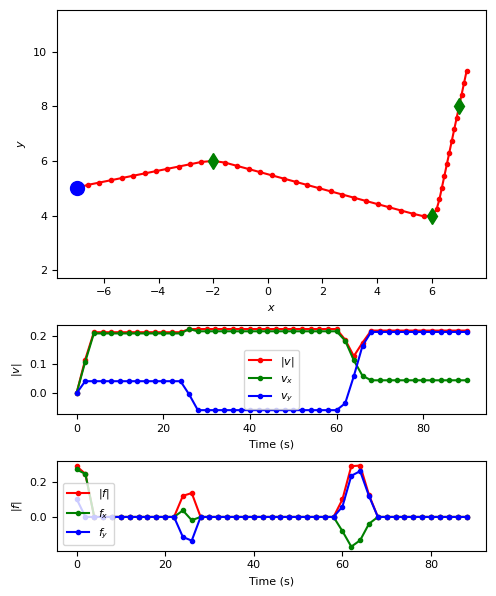

In [253]:
%matplotlib inline 

time_span = np.linspace(0, tf, N+1)
plot(T=time_span, F=f, S=s, s0=s0, sf=sf)


### Experiment 2

In [254]:
                                                                                                                                                                                                            # Based on Fig. 8
# Initial and final states
s0 = np.array([-7., 0., 5., 0.])

# Prediction horizon
tf = 90.0
N = np.int32(tf/dt)

sf = np.array([[-2, None, 6, None,],
            [6, None, 4, None],
            [7, None, 8, None]], dtype=np.float32)

C = create_env2()

s, f, Tf = plan2(C=C, N=N, s0=s0, sf=sf, wmax=np.deg2rad(15.0), mass=5., dt=2., solver="SCIP")

vmax' = 0.222229876633906
fmax = 0.2908982282671854
Tf = [90.]
J = 90.0018499208238


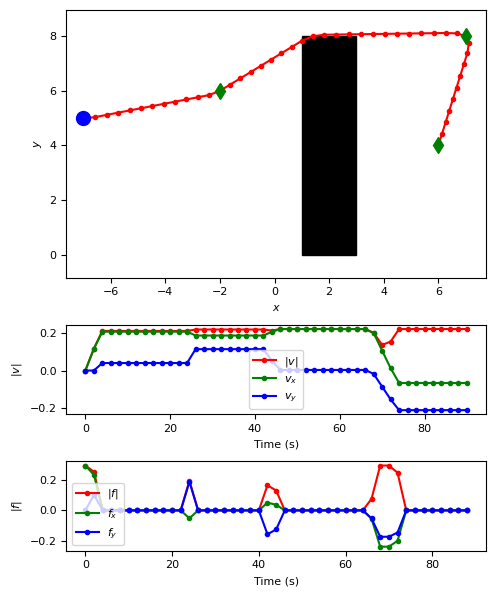

In [255]:
%matplotlib inline 

time_span = np.linspace(0, tf, N+1)
plot(T=time_span, C=C, F=f, S=s, s0=s0, sf=sf)
